# CoCiP

[Contrail Cirrus Predicition (CoCiP)](https://gmd.copernicus.org/articles/5/543/2012/) model evaluation along a flight trajectory.

## References

- Schumann, U. “A Contrail Cirrus Prediction Model.” Geoscientific Model Development 5, no. 3 (May 3, 2012): 543–80. https://doi.org/10.5194/gmd-5-543-2012.
- Schumann, U., B. Mayer, K. Graf, and H. Mannstein. “A Parametric Radiative Forcing Model for Contrail Cirrus.” Journal of Applied Meteorology and Climatology 51, no. 7 (July 2012): 1391–1406. https://doi.org/10.1175/JAMC-D-11-0242.1.
- Teoh, Roger, Ulrich Schumann, Arnab Majumdar, and Marc E. J. Stettler. “Mitigating the Climate Forcing of Aircraft Contrails by Small-Scale Diversions and Technology Adoption.” Environmental Science & Technology 54, no. 5 (March 3, 2020): 2941–50. https://doi.org/10.1021/acs.est.9b05608.
- Teoh, Roger, Ulrich Schumann, Edward Gryspeerdt, Marc Shapiro, Jarlath Molloy, George Koudis, Christiane Voigt, and Marc Stettler. “Aviation Contrail Climate Effects in the North Atlantic from 2016&ndash;2021.” Atmospheric Chemistry and Physics Discussions, March 30, 2022, 1–27. https://doi.org/10.5194/acp-2022-169.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pycontrails import Flight, Aircraft
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling

## Set Domain

time / altitude

In [2]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
pressure_levels = [300, 250, 200]

## Download meteorology data from ECMWF

This demo uses [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) via the [Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/) for met data.
This requires account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home) and  local `~/.cdsapirc` file with credentials.

> Note this will download ~1 GB of meteorology data to your computer

In [3]:
era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables + Cocip.optional_met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time_bounds, variables=Cocip.rad_variables)

In [4]:
# download data from ERA5 (or open from cache)
met = era5pl.open_metdataset(xr_kwargs=dict(parallel=False))
rad = era5sl.open_metdataset(xr_kwargs=dict(parallel=False))

## Load Flight Data

`Flight` can be loaded from CSV, parquet, or created from a pandas DataFrame

In [5]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test",
    # set constants along flight path
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,  # non-volatile emissions index
}
aircraft = Aircraft(aircraft_type="E190", wingspan=48, n_engine=2)

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-25, -40, 100)
df["latitude"] = np.linspace(34, 40, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["engine_efficiency"] = np.linspace(0.34, 0.35, 100)
df["fuel_flow"] = np.linspace(2.1, 2.4, 100)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154345, 100)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)

flight = Flight(df, aircraft=aircraft, attrs=flight_attrs)
flight

Flight [7 keys x 100 length, 12 attributes]
	Keys: longitude, latitude, altitude, engine_efficiency, fuel_flow, ..., time
	Attributes:
	time                [2022-03-01 00:15:00, 2022-03-01 02:30:00]
	longitude           [-40.0, -25.0]
	latitude            [34.0, 40.0]
	altitude            [10900.0, 10900.0]
	aircraft_type       E190
	aircraft_name       None
	wingspan            48
	engine_name         None
	n_engine            2
	max_mach            None
	max_altitude        None
	flight_id           test
	true_airspeed       226.099920796651
	thrust              0.22
	nvpm_ei_n           1897462000000000.0
	crs                 EPSG:4326

## Run `Cocip` on a single flight

In this first example, the `Flight` has aircraft performance (i.e. `nvpm_ei_n`) hardcoded into the data as constants. This data is assumed to be constant at every flight waypoint. 

> **Caveat**

> - When the `Cocip` model is run on one `Flight`, the default behavior is to **downselect the meteorology**
to a region surrounding the flight and **process the meteorology**  (i.e. humidity scaling, `tau_cirrus`) on the smaller domain. The implications of this processing is each instance of a single-flight `Cocip` model should *only be run once*.
> - We ignore the warning here about humidity scaling for ECMWF data sources 

In [6]:
params = {
    "dt_integration": np.timedelta64(10, "m"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # based on Teoh 2020 and Teoh 2022 - https://acp.copernicus.org/preprints/acp-2022-169/acp-2022-169.pdf
    # Here we use an example of constantly scaling the humidity value by 0.99
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=0.99),
}
cocip = Cocip(met=met, rad=rad, params=params)

In [7]:
output_flight = cocip.eval(source=flight)

## Explore Flight Output

The `output_flight` object holds roughly 50 variables of interest. The energy forcing `ef` field is a primary model output. Waypoints not producing persistent contrails are assigned an `ef` value of 0.

In [8]:
df = output_flight.dataframe  # cocip.source.dataframe is equivalent
df.head()

,waypoint,longitude,latitude,altitude,engine_efficiency,fuel_flow,aircraft_mass,time,flight_id,level,...,n_ice_per_m_1,ef,contrail_age,sdr_mean,rsr_mean,olr_mean,rf_sw_mean,rf_lw_mean,rf_net_mean,cocip
0,0,-25.000000,34.000000,10900.0,0.340000,2.100000,154445.000000,2022-03-01 00:15:00.000000000,test,229.908663,...,4.915332e+12,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,-25.151515,34.060606,10900.0,0.340101,2.103030,154443.989899,2022-03-01 00:16:21.818181818,test,229.908663,...,7.908453e+12,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,-25.303030,34.121212,10900.0,0.340202,2.106061,154442.979798,2022-03-01 00:17:43.636363636,test,229.908663,...,9.780731e+12,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,3,-25.454545,34.181818,10900.0,0.340303,2.109091,154441.969697,2022-03-01 00:19:05.454545454,test,229.908663,...,1.097854e+13,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,-25.606061,34.242424,10900.0,0.340404,2.112121,154440.959596,2022-03-01 00:20:27.272727272,test,229.908663,...,1.164095e+13,0.0,0 days,NaN,NaN,NaN,NaN,NaN,NaN,0.0


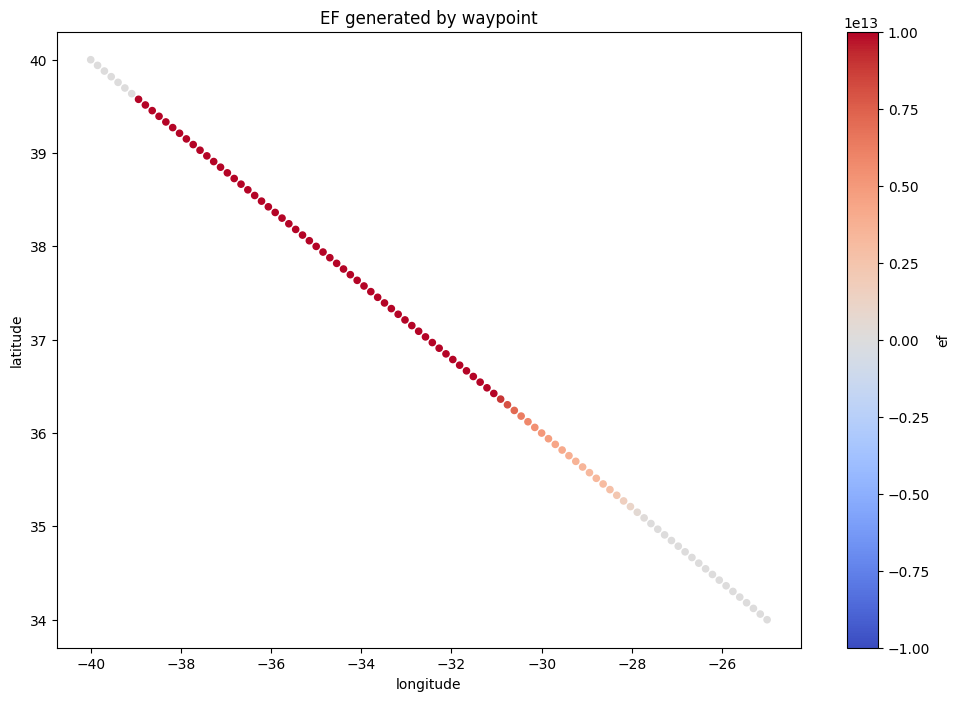

In [9]:
df.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    figsize=(12, 8),
    vmin=-1e13,
    vmax=1e13,
    title="EF generated by waypoint",
);

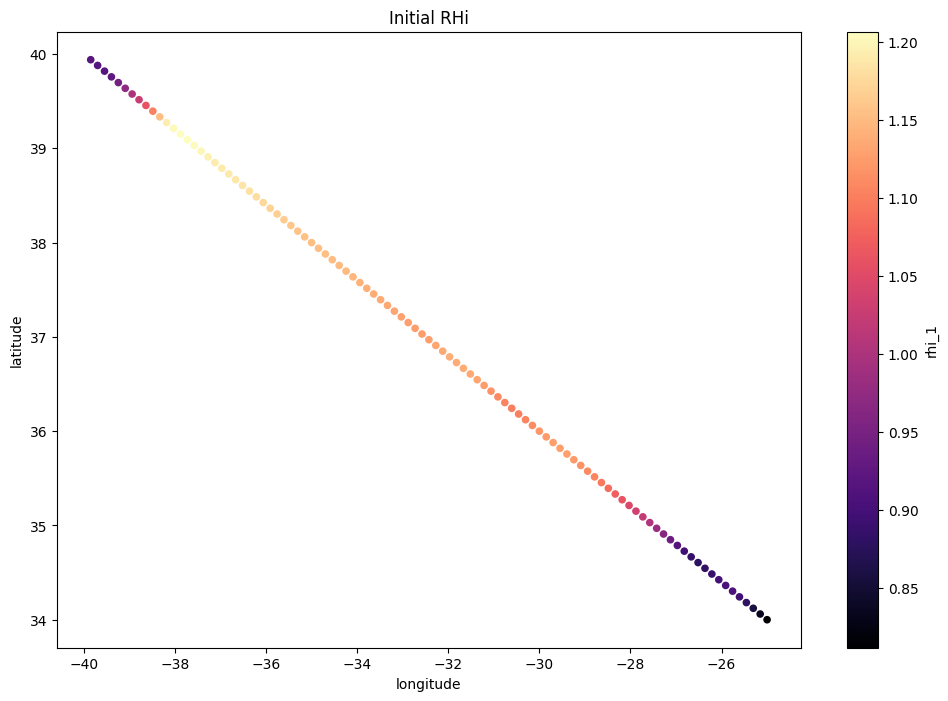

In [10]:
df.plot.scatter(
    x="longitude", y="latitude", c="rhi_1", cmap="magma", figsize=(12, 8), title="Initial RHi"
);

## Explore Contrail Output

- The `cocip.contrail` attribute is a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) representation of the contrail waypoints.
- The `cocip.contrail_dataset` attribute is a [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) representation of the contrail waypoints.

In [11]:
contrail = cocip.contrail
contrail.head()

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,tau_contrail,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours
0,16,test,2022-03-01 00:36:49.090909090,2022-03-01 00:40:00,0 days 00:03:10.909090910,-27.378231,34.922638,10844.400220,231.925491,True,...,0.011011,1.235043e-20,0.000043,0.0,0.068228,0.068228,True,6.692479e+08,2,0.053030
1,17,test,2022-03-01 00:38:10.909090909,2022-03-01 00:40:00,0 days 00:01:49.090909091,-27.548940,35.003593,10844.712950,231.914107,True,...,0.129146,1.869578e-19,0.000069,0.0,1.563418,1.563418,True,8.580769e+08,2,0.030303
2,18,test,2022-03-01 00:39:32.727272727,2022-03-01 00:40:00,0 days 00:00:00,-27.720435,35.084279,10844.521444,231.921078,False,...,0.332404,3.208356e-19,0.000231,0.0,3.895804,3.895804,True,0.000000e+00,2,0.000000
0,17,test,2022-03-01 00:38:10.909090909,2022-03-01 00:50:00,0 days 00:11:49.090909091,-27.402288,34.856294,10844.941406,231.905791,True,...,0.029814,8.479606e-20,0.000022,0.0,0.461217,0.461217,True,6.442485e+09,3,0.196970
1,18,test,2022-03-01 00:39:32.727272727,2022-03-01 00:50:00,0 days 00:10:27.272727273,-27.570210,34.938334,10846.431025,231.851575,True,...,0.041419,2.521284e-19,0.000024,0.0,0.798806,0.798806,True,8.484541e+09,3,0.174242


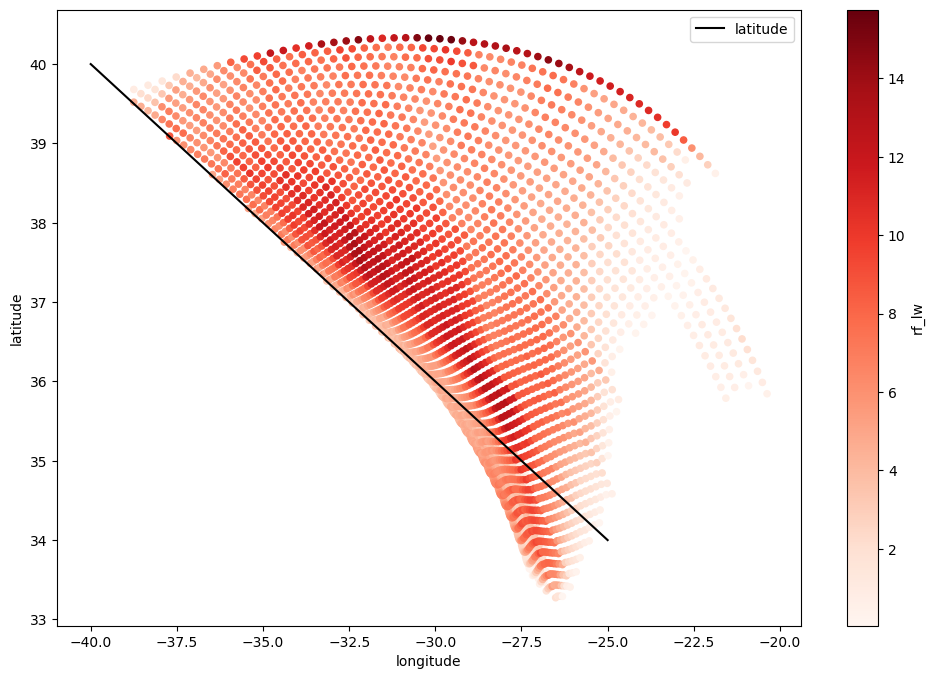

In [12]:
ax = cocip.source.dataframe.plot("longitude", "latitude", color="k", figsize=(12, 8))
cocip.contrail.plot.scatter("longitude", "latitude", c="rf_lw", cmap="Reds", ax=ax);

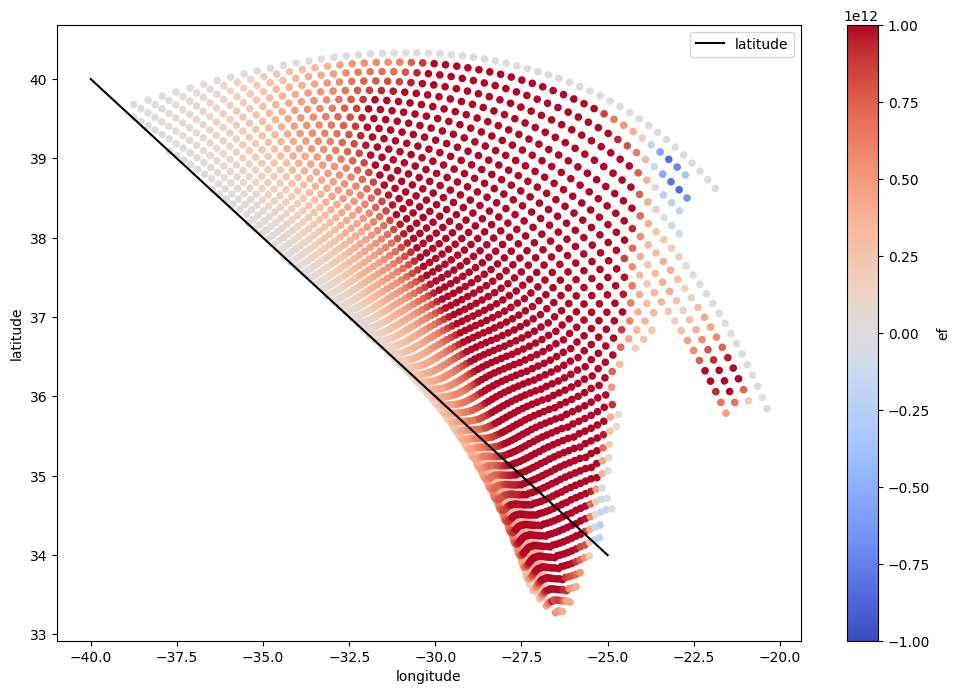

In [13]:
ax = cocip.source.dataframe.plot("longitude", "latitude", color="k", figsize=(12, 8))
cocip.contrail.plot.scatter(
    "longitude", "latitude", c="ef", cmap="coolwarm", vmin=-1e12, vmax=1e12, ax=ax
);

## Explore Flight Summary

A curated set of statistics available after a `Flight` has been run through `eval`

In [14]:
flight_statistics = cocip.output_flight_statistics()
flight_statistics

Flight ID                                                         test
ATYP                                                              E190
First wypt                               2022-03-01T00:15:00.000000000
Last wypt                                2022-03-01T02:30:00.000000000
Total flight dist (km)                                     1489.372552
Total fuel burn (kg)                                      18212.727273
OPE mean                                                         0.345
Fuel methodology                                                  None
ATYP assumed                                                      None
Engine name                                                       None
Aircraft mass mean (kg)                                       154395.0
BC EI_n mean (kg-1)                                 1897462000000000.0
BC methodology                                                    None
Short-lived contrails                                             True
Initia

## Run Cocip on Multiple Flights

Run multiple `Flight` inputs on a single set of meteorology.

For this demo, we'll copy the original flight and tweak its longitude and latitudes values.

In [15]:
flights = []
for i in range(10):
    fl = flight.copy()
    fl.attrs.update(flight_id=f"test-{i}")
    fl.update(latitude=flight["latitude"] + i)
    fl.update(longitude=flight["longitude"] + i)
    flights.append(fl)

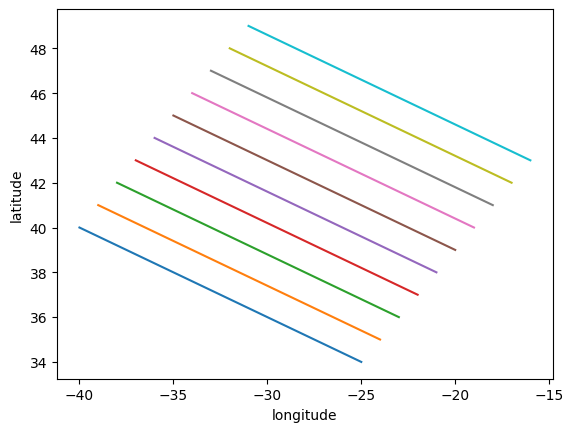

In [16]:
# Visualize the "test" flights
fig, ax = plt.subplots()
for fl in flights:
    fl.plot(ax=ax)

Run the `Cocip` model over a `list[Flight]` objects

In [17]:
cocip = Cocip(
    met=met,
    rad=rad,
    process_emissions=False,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
)

# returns list of Flight outputs
output_flights = cocip.eval(source=flights)

In [18]:
# print EF for each flight
for fl in output_flights:
    print(f"{fl.attrs['flight_id']}: {np.sum(fl['ef'])}")

test-0: 2225891392322549.5
test-1: 1616778230113169.5
test-2: 1375891457519733.0
test-3: 717105206813399.4
test-4: 784319726893.4614
test-5: 2031278959.5388467
test-6: 0.0
test-7: 0.0
test-8: 0.0
test-9: 0.0


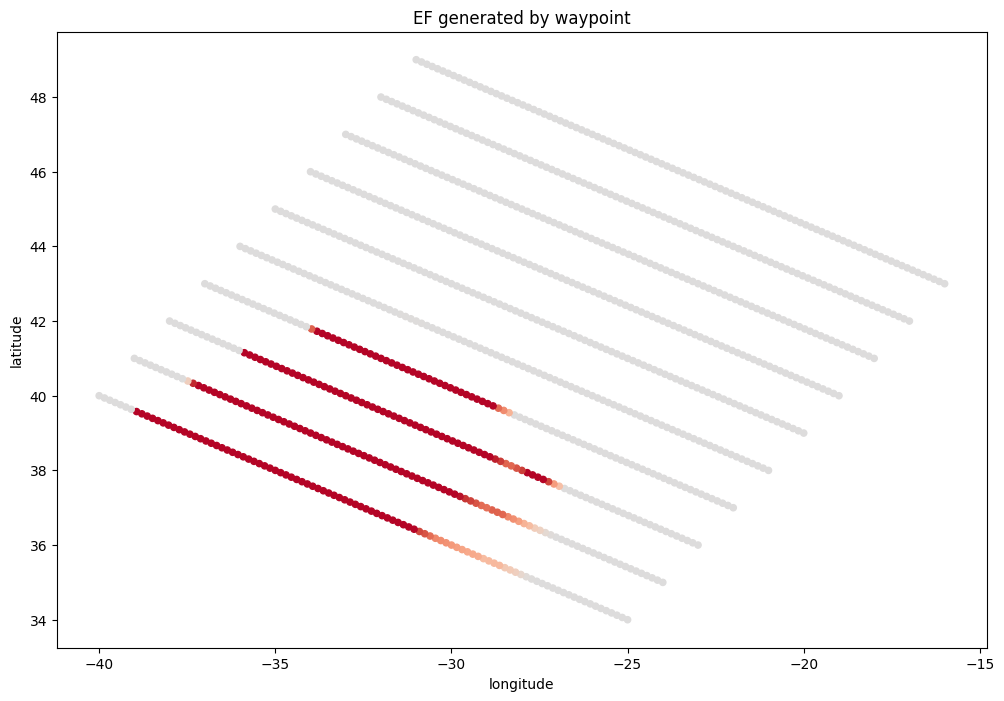

In [19]:
# Visualize the "ef" of each flight
fig, ax = plt.subplots()
for fl in output_flights:
    fl.dataframe.plot.scatter(
        x="longitude",
        y="latitude",
        c="ef",
        cmap="coolwarm",
        figsize=(12, 8),
        vmin=-1e13,
        vmax=1e13,
        title="EF generated by waypoint",
        ax=ax,
        colorbar=False,
    );

## Use BADA aircraft performance data

Uses the [BADA](https://www.eurocontrol.int/model/bada) model to estimate emissions.

> Requires private extension [pycontrails-bada](https://github.com/contrailcirrus/pycontrails-bada) and BADA License for performance data files.
>
> Install with `pip install ".[bada]"`

First create a Flight that does not have emissions data associated:

In [20]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test-bada",
}
aircraft = Aircraft(aircraft_type="E190")

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-40, -55, 100)
df["latitude"] = np.linspace(38, 45, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)
fl = Flight(data=df, aircraft=aircraft, attrs=flight_attrs)

In [21]:
# create BADA model
from pycontrails.ext.bada import BADAFlight

bada_model = BADAFlight()

In [22]:
cocip = Cocip(
    met=met,
    rad=rad,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
    aircraft_performance=bada_model,
)

output_flight = cocip.eval(source=fl)

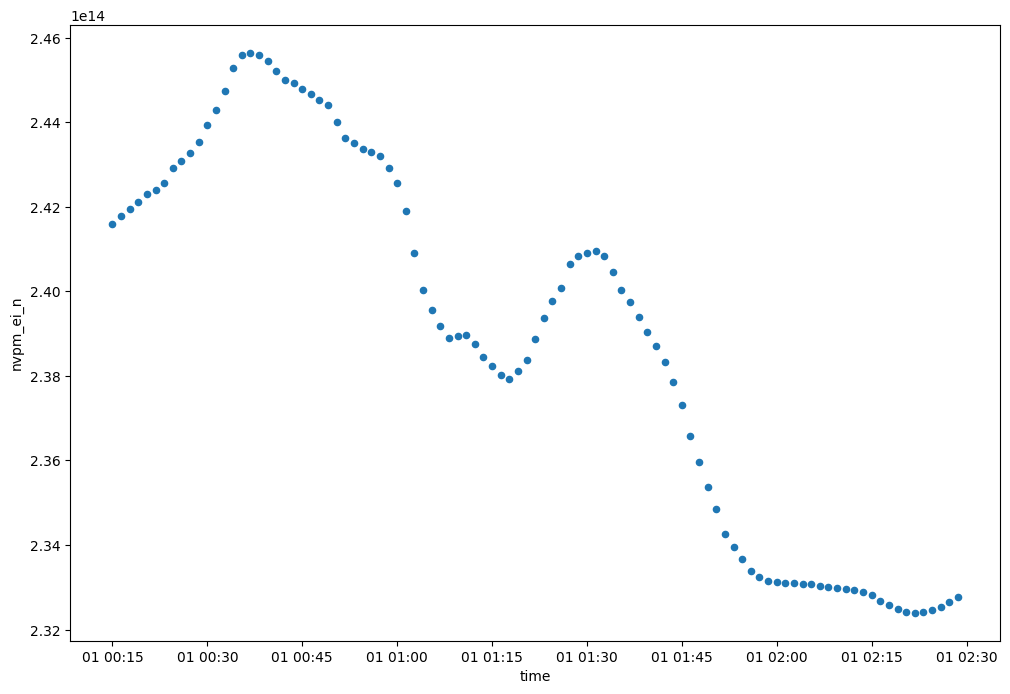

In [23]:
output_flight.dataframe.plot.scatter(x="time", y="nvpm_ei_n", figsize=(12, 8));

## Output contrail cirrus optical depth

> Note this is only a preliminary implementation and will be changed in the future

The example below uses the contrail cirrus output from 1 flight, but the `df_contrails` input can include 
contrail cirrus from multiple flights.

To run multiple flights, concatenate `Cocip.contrail` outputs from multiple flights and feed in to `grid_cirrus.<>` methods as `df_contrails`.
Unique `flight_id` column will have to be added to the `Cocip.contrail` output before concatenation.

In [24]:
from pycontrails.models.cocip.output import grid_cirrus

In [25]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test",
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,
}
aircraft = Aircraft(aircraft_type="E190", wingspan=48, n_engine=2)

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-40, -55, 100)
df["latitude"] = np.linspace(38, 45, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["engine_efficiency"] = np.linspace(0.34, 0.35, 100)  # ope
df["fuel_flow"] = np.linspace(2.1, 2.4, 100)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154345, 100)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)
fl = Flight(data=df, aircraft=aircraft, attrs=flight_attrs)

In [26]:
# run model
cocip = Cocip(
    met=met,
    rad=rad,
    process_emissions=False,
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99),
)
output_flight = cocip.eval(source=fl)

In [28]:
# get dataframe of contrail waypoints
df_contrails = cocip.contrail
df_contrails["flight_id"] = cocip.source.attrs["flight_id"]

In [29]:
w = df_contrails["longitude"].min()
e = df_contrails["longitude"].max()
s = df_contrails["latitude"].min()
n = df_contrails["latitude"].max()
bbox = [w, s, e, n]

# get required met data, and downselect within bounding box of contrails
cloud_cover = met["fraction_of_cloud_cover"].downselect(bbox).data
tau_cirrus = met["tau_cirrus"].downselect(bbox).data

In [30]:
# output summary for each timestep
grid_summary = grid_cirrus.cirrus_summary_statistics(
    df_contrails,
    cloud_cover,
    tau_cirrus,
)
grid_summary

,Total Cirrus Cover Pct,Natural Cirrus Cover Pct,Contrail Cirrus Cover Pct,Contrail Cirrus Cover Pct - Clear Sky
2022-03-01 00:00:00,58.539187,58.539187,0.000000,0.000000
2022-03-01 01:00:00,64.982509,64.982509,0.000000,0.005523
2022-03-01 02:00:00,70.154832,70.149355,0.005477,0.010994
2022-03-01 03:00:00,74.337517,74.329301,0.008216,0.040949
2022-03-01 04:00:00,77.155953,77.145080,0.010872,0.049024
2022-03-01 05:00:00,78.293582,78.280037,0.013545,0.092370
2022-03-01 06:00:00,78.912153,78.901242,0.010911,0.103788
2022-03-01 07:00:00,78.295355,78.289913,0.005442,0.057155
2022-03-01 08:00:00,77.385170,77.385170,0.000000,0.000000
2022-03-01 09:00:00,79.607413,79.607413,0.000000,0.000000


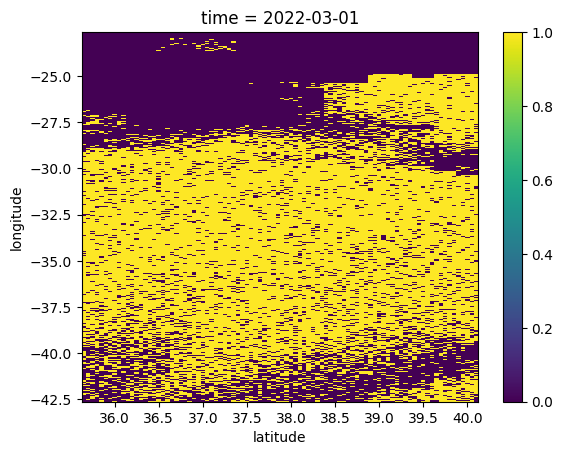

In [31]:
# natural cirrus cover
cc_natural, tau_natural = grid_cirrus._get_gridded_natural_cirrus_cover_and_tau(
    cloud_cover, tau_cirrus
)
cc_natural.isel(time=0).plot();

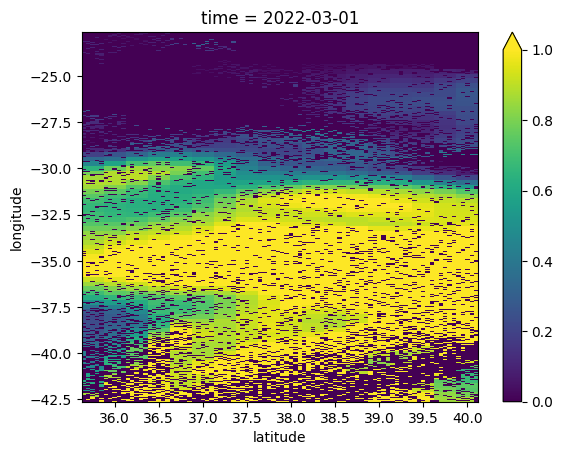

In [32]:
tau_natural.isel(time=0).plot(vmax=1);

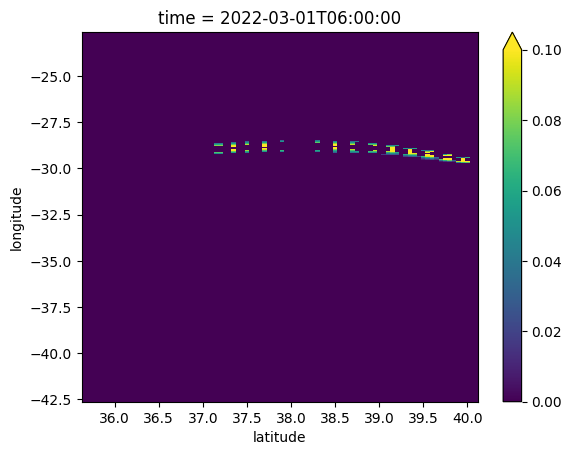

In [33]:
# optical depth of contrails
tau_contrails_clear = grid_cirrus.get_gridded_tau_contrail(df_contrails, cc_natural)
tau_contrails_clear.isel(time=6).plot(vmax=0.1);